In [4]:
audio_path_noqueen = 'E:\\Queenless\\archive\\nuhive_processed\\test\\noqueen\\CF001 - Missing Queen - Day --0-2.wav'
audio_path_nobee = 'E:\\Queenless\\archive\\nuhive_processed\\test\\nobee\\CF003 - Active - Day - (214)-7-3.wav'
audio_path_bee = 'E:\\Queenless\\archive\\nuhive_processed\\test\\bee\\CF003 - Active - Day - (214)-12-1.wav'

Mel-Frequency Cepstral Coefficients (MFCCs)

In [5]:
import numpy as np
import scipy.fftpack as fftpack
import scipy.signal as signal
import librosa

def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Bước 1: Pre-emphasis - Lọc thông cao
    """
    emphasized_signal = np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1]) # y(t) = x(t) - alpha*x(t-1)
    return emphasized_signal

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Bước 2: Chia khung (Framing)
    - frame_size: kích thước khung (số giây)
    - frame_stride: bước nhảy giữa các khung (số giây)
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    # Zero-padding nếu cần
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Bước 3: Áp dụng cửa sổ Hamming cho mỗi khung
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    windowed_frames = frames * hamming
    return windowed_frames

def fft_frames(frames, NFFT=512):
    """
    Bước 4: Tính FFT cho mỗi khung
    """
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    return mag_frames

def power_spectrum(mag_frames, NFFT=512):
    """
    Bước 4.1: Tính phổ công suất của mỗi khung
    """
    return (1.0 / NFFT) * (mag_frames ** 2)

def mel_filterbank(sample_rate, NFFT, nfilt=26, low_freq=0, high_freq=None):
    """
    Bước 5: Tạo Mel filterbank
    """
    if high_freq is None:
        high_freq = sample_rate / 2

    # Chuyển Hz sang Mel
    low_mel = 2595 * np.log10(1 + low_freq / 700.0)
    high_mel = 2595 * np.log10(1 + high_freq / 700.0)
    mel_points = np.linspace(low_mel, high_mel, nfilt + 2)
    # Chuyển lại từ Mel sang Hz
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # giới hạn trái
        f_m = int(bin[m])             # trung tâm
        f_m_plus = int(bin[m + 1])    # giới hạn phải

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    return fbank

def compute_mfcc(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, 
                 pre_emph=0.97, NFFT=512, nfilt=26, num_ceps=13):
    """
    Hàm tích hợp các bước tính MFCC:
      1. Pre-emphasis
      2. Framing
      3. Windowing
      4. FFT và Power Spectrum
      5. Áp dụng Mel Filterbank
      6. Logarithm
      7. DCT để thu MFCCs
    """
    # Bước 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal_in, pre_emph)

    # Bước 2: Framing
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)

    # Bước 3: Windowing
    windowed_frames = windowing(frames)

    # Bước 4: FFT và Power Spectrum
    mag_frames = fft_frames(windowed_frames, NFFT)
    pow_frames = power_spectrum(mag_frames, NFFT)

    # Bước 5: Mel Filterbank
    fbank = mel_filterbank(sample_rate, NFFT, nfilt)
    filter_banks = np.dot(pow_frames, fbank.T)
    # Tránh log(0)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)

    # Bước 6: Lấy logarithm của năng lượng trên mỗi dải Mel
    log_fbank = np.log(filter_banks)

    # Bước 7: DCT (Discrete Cosine Transform) để thu được MFCCs
    mfccs = fftpack.dct(log_fbank, type=2, axis=1, norm='ortho')[:, :num_ceps]
    return mfccs



In [6]:
signal_noqueen, sr_noqueen = librosa.load(audio_path_noqueen, sr=None)
signal_nobee, sr_nobee = librosa.load(audio_path_nobee, sr=None)
signal_bee, sr_bee = librosa.load(audio_path_bee, sr=None)

# Compute MFCC features for all three signals
mfcc_noqueen = compute_mfcc(signal_noqueen, sr_noqueen)
mfcc_nobee = compute_mfcc(signal_nobee, sr_nobee)
mfcc_bee = compute_mfcc(signal_bee, sr_bee)

# Print the shapes of the MFCC features
print("Kích thước MFCC (no queen):", mfcc_noqueen.shape)
print("Kích thước MFCC (no bee):", mfcc_nobee.shape)
print("Kích thước MFCC (bee):", mfcc_bee.shape)

Kích thước MFCC (no queen): (199, 13)
Kích thước MFCC (no bee): (199, 13)
Kích thước MFCC (bee): (199, 13)


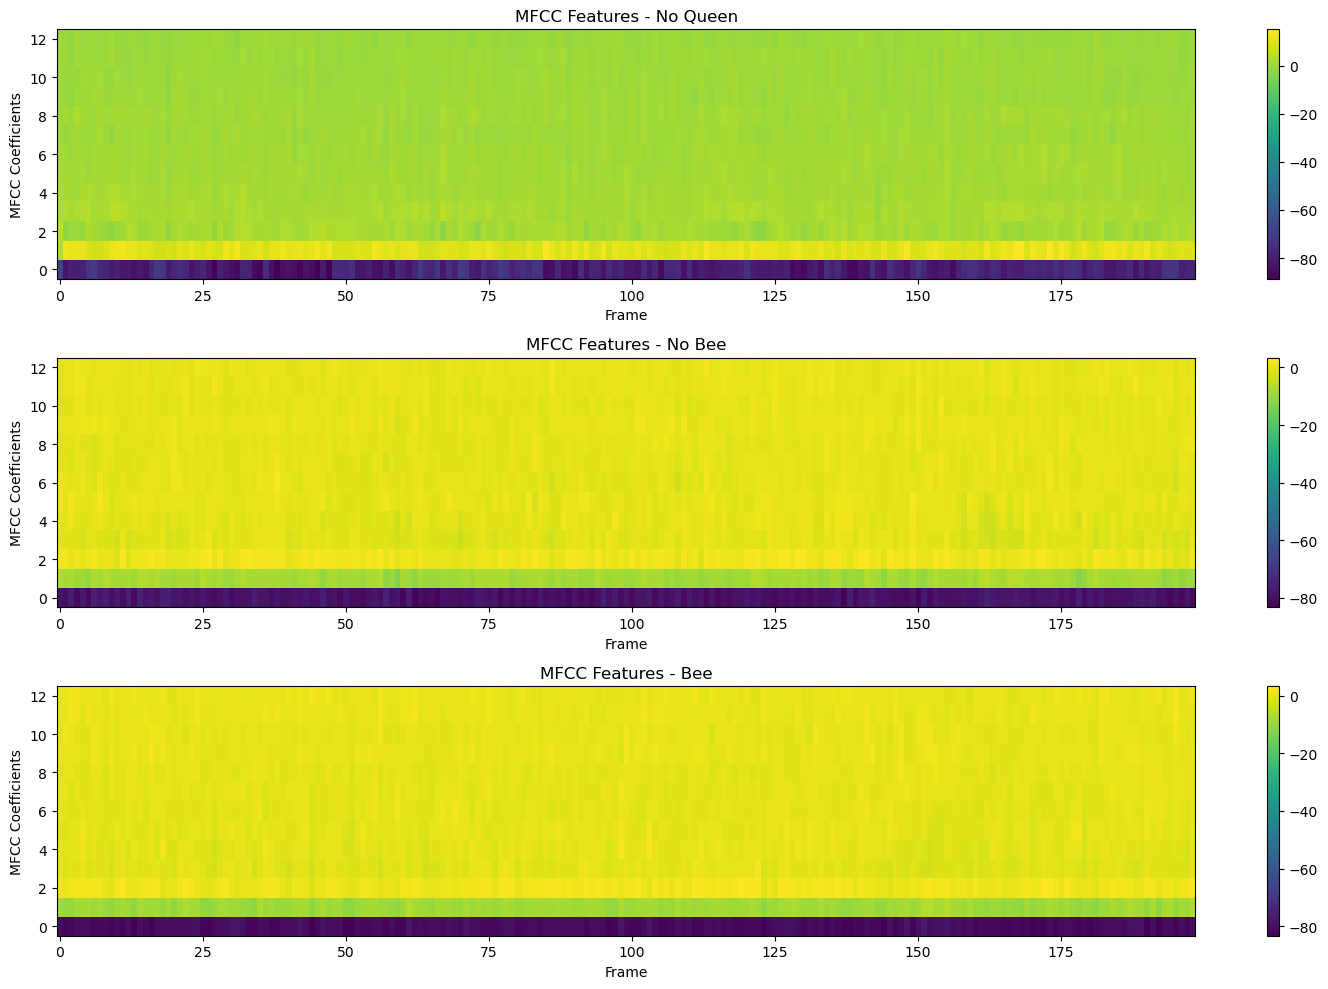

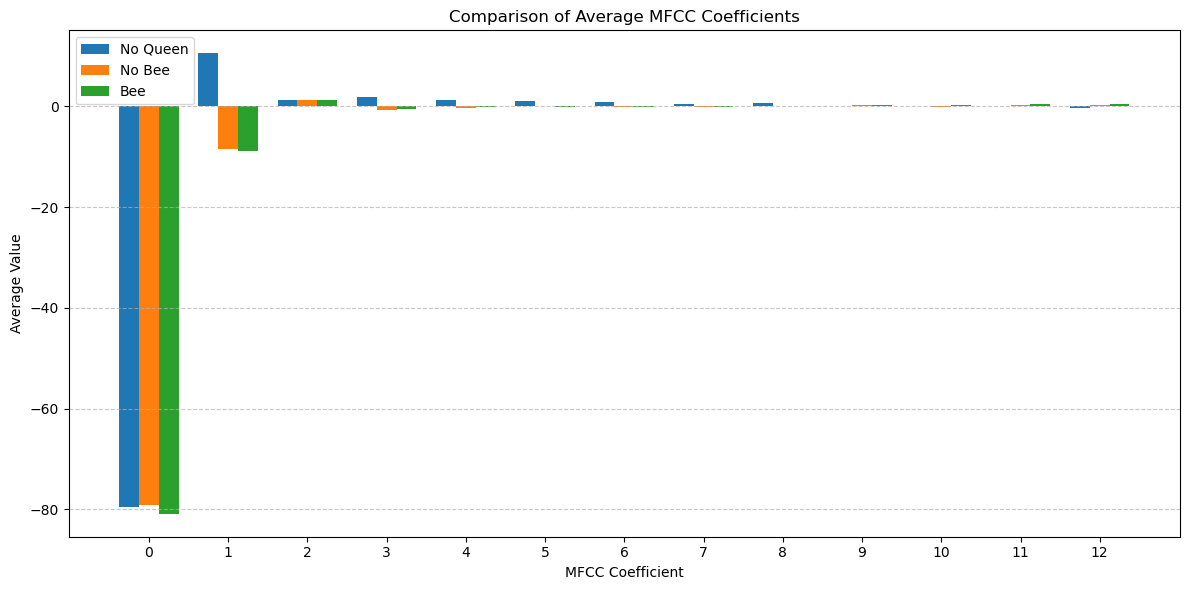

In [7]:
import matplotlib.pyplot as plt

# Visualize the MFCC features
plt.figure(figsize=(15, 10))

# Plot MFCC for no-queen signal
plt.subplot(3, 1, 1)
plt.imshow(mfcc_noqueen.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('MFCC Features - No Queen')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Frame')

# Plot MFCC for no-bee signal
plt.subplot(3, 1, 2)
plt.imshow(mfcc_nobee.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('MFCC Features - No Bee')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Frame')

# Plot MFCC for bee signal
plt.subplot(3, 1, 3)
plt.imshow(mfcc_bee.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar()
plt.title('MFCC Features - Bee')
plt.ylabel('MFCC Coefficients')
plt.xlabel('Frame')

plt.tight_layout()
plt.show()

# Also create a comparison of average MFCC coefficients
plt.figure(figsize=(12, 6))

# Calculate mean of MFCC coefficients across frames
mean_mfcc_noqueen = np.mean(mfcc_noqueen, axis=0)
mean_mfcc_nobee = np.mean(mfcc_nobee, axis=0)
mean_mfcc_bee = np.mean(mfcc_bee, axis=0)

# Plot average MFCC coefficients
x = np.arange(len(mean_mfcc_noqueen))
width = 0.25

plt.bar(x - width, mean_mfcc_noqueen, width, label='No Queen')
plt.bar(x, mean_mfcc_nobee, width, label='No Bee')
plt.bar(x + width, mean_mfcc_bee, width, label='Bee')

plt.xlabel('MFCC Coefficient')
plt.ylabel('Average Value')
plt.title('Comparison of Average MFCC Coefficients')
plt.xticks(x)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Short-Time Fourier Transform (STFT)

In [10]:
from scipy.signal import stft, get_window

def compute_stft(signal_in, sample_rate, window_size=2048, hop_size=512, window_type='hann'):
    """
    Hàm tính Short-Time Fourier Transform (STFT) của tín hiệu âm thanh.
    
    Args:
    - signal_in: Tín hiệu âm thanh đầu vào (mảng numpy)
    - sample_rate: Tỷ lệ lấy mẫu của tín hiệu (Hz)
    - window_size: Kích thước cửa sổ (số mẫu)
    - hop_size: Bước nhảy giữa các khung (số mẫu)
    - window_type: Loại cửa sổ sử dụng ('hann', 'hamming', v.v.)

    Returns:
    - Zxx: Kết quả STFT (biến đổi Fourier trong miền thời gian-tần số)
    """
    # Áp dụng cửa sổ vào tín hiệu
    window = get_window(window_type, window_size)
    
    # Tính toán STFT bằng hàm scipy.signal.stft
    f, t, Zxx = stft(signal_in, fs=sample_rate, window=window, nperseg=window_size, noverlap=hop_size)
    
    return f, t, Zxx


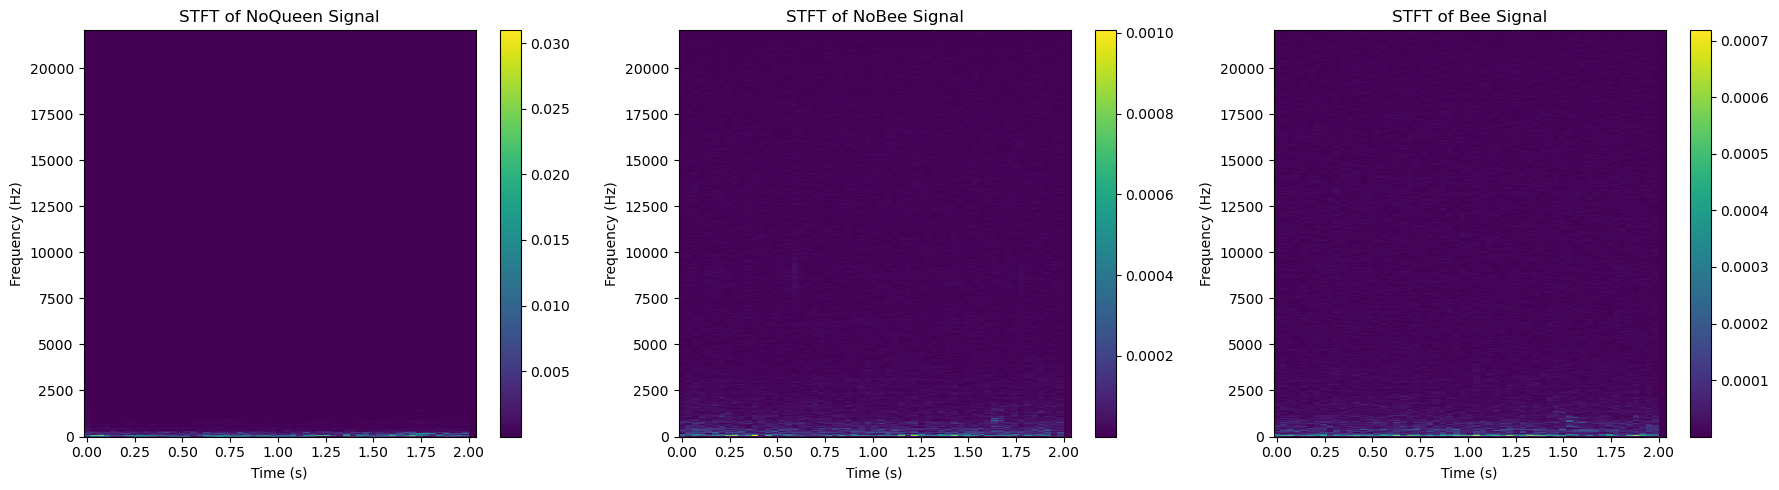

In [12]:
def plot_stft_three_classes(f_noqueen, t_noqueen, Zxx_noqueen, 
                           f_nobee, t_nobee, Zxx_nobee,
                           f_bee, t_bee, Zxx_bee):
    """
    Hàm để vẽ biểu đồ STFT (Time-Frequency Spectrogram) cho ba lớp âm thanh.
    
    Args:
    - f_*: Tần số
    - t_*: Thời gian
    - Zxx_*: Kết quả STFT
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot STFT for NoQueen signal
    cax1 = ax1.pcolormesh(t_noqueen, f_noqueen, np.abs(Zxx_noqueen), shading='auto')
    fig.colorbar(cax1, ax=ax1)
    ax1.set_title('STFT of NoQueen Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')

    # Plot STFT for NoBee signal
    cax2 = ax2.pcolormesh(t_nobee, f_nobee, np.abs(Zxx_nobee), shading='auto')
    fig.colorbar(cax2, ax=ax2)
    ax2.set_title('STFT of NoBee Signal')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    
    # Plot STFT for Bee signal
    cax3 = ax3.pcolormesh(t_bee, f_bee, np.abs(Zxx_bee), shading='auto')
    fig.colorbar(cax3, ax=ax3)
    ax3.set_title('STFT of Bee Signal')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

# Load the audio signals
signal_noqueen, sr_noqueen = librosa.load(audio_path_noqueen, sr=None)
signal_nobee, sr_nobee = librosa.load(audio_path_nobee, sr=None)
signal_bee, sr_bee = librosa.load(audio_path_bee, sr=None)

# Compute STFT for all three signals
f_noqueen, t_noqueen, Zxx_noqueen = compute_stft(signal_noqueen, sr_noqueen)
f_nobee, t_nobee, Zxx_nobee = compute_stft(signal_nobee, sr_nobee)
f_bee, t_bee, Zxx_bee = compute_stft(signal_bee, sr_bee)

# Plot STFTs (full frequency range)
plot_stft_three_classes(
    f_noqueen, t_noqueen, Zxx_noqueen,
    f_nobee, t_nobee, Zxx_nobee,
    f_bee, t_bee, Zxx_bee
)

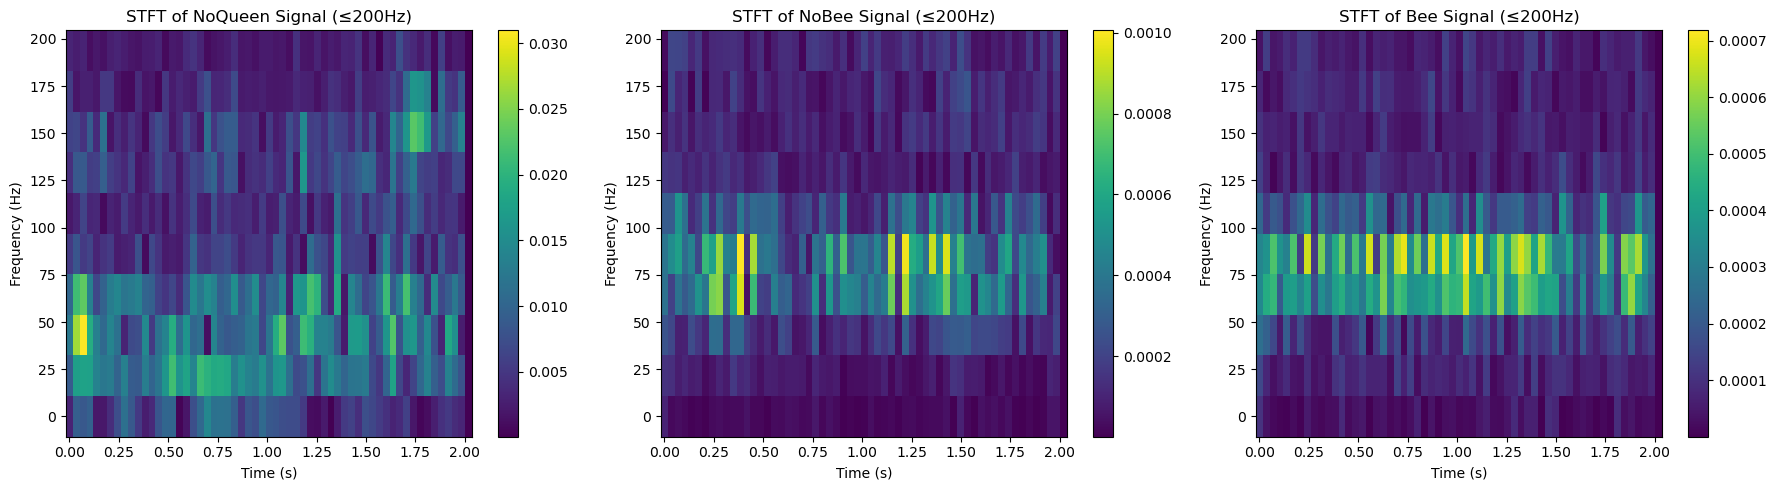

In [14]:
# Hàm để vẽ biểu đồ STFT với giới hạn tần số
def plot_stft_with_freq_limit(f_noqueen, t_noqueen, Zxx_noqueen, 
                             f_nobee, t_nobee, Zxx_nobee,
                             f_bee, t_bee, Zxx_bee, 
                             max_freq=1000):
    """
    Hàm để vẽ biểu đồ STFT (Time-Frequency Spectrogram) cho ba lớp âm thanh,
    giới hạn ở tần số max_freq.
    """
    # Create frequency masks for cutoff
    freq_mask_noqueen = f_noqueen <= max_freq
    freq_mask_nobee = f_nobee <= max_freq
    freq_mask_bee = f_bee <= max_freq
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot STFT for NoQueen signal with frequency limit
    cax1 = ax1.pcolormesh(t_noqueen, 
                         f_noqueen[freq_mask_noqueen], 
                         np.abs(Zxx_noqueen[freq_mask_noqueen]), 
                         shading='auto')
    fig.colorbar(cax1, ax=ax1)
    ax1.set_title(f'STFT of NoQueen Signal (≤{max_freq}Hz)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Frequency (Hz)')

    # Plot STFT for NoBee signal with frequency limit
    cax2 = ax2.pcolormesh(t_nobee, 
                         f_nobee[freq_mask_nobee], 
                         np.abs(Zxx_nobee[freq_mask_nobee]), 
                         shading='auto')
    fig.colorbar(cax2, ax=ax2)
    ax2.set_title(f'STFT of NoBee Signal (≤{max_freq}Hz)')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Frequency (Hz)')
    
    # Plot STFT for Bee signal with frequency limit
    cax3 = ax3.pcolormesh(t_bee, 
                         f_bee[freq_mask_bee], 
                         np.abs(Zxx_bee[freq_mask_bee]), 
                         shading='auto')
    fig.colorbar(cax3, ax=ax3)
    ax3.set_title(f'STFT of Bee Signal (≤{max_freq}Hz)')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

plot_stft_with_freq_limit(
    f_noqueen, t_noqueen, Zxx_noqueen,
    f_nobee, t_nobee, Zxx_nobee,
    f_bee, t_bee, Zxx_bee,
    max_freq=200
)

Fast Fourier Transform (FFT)

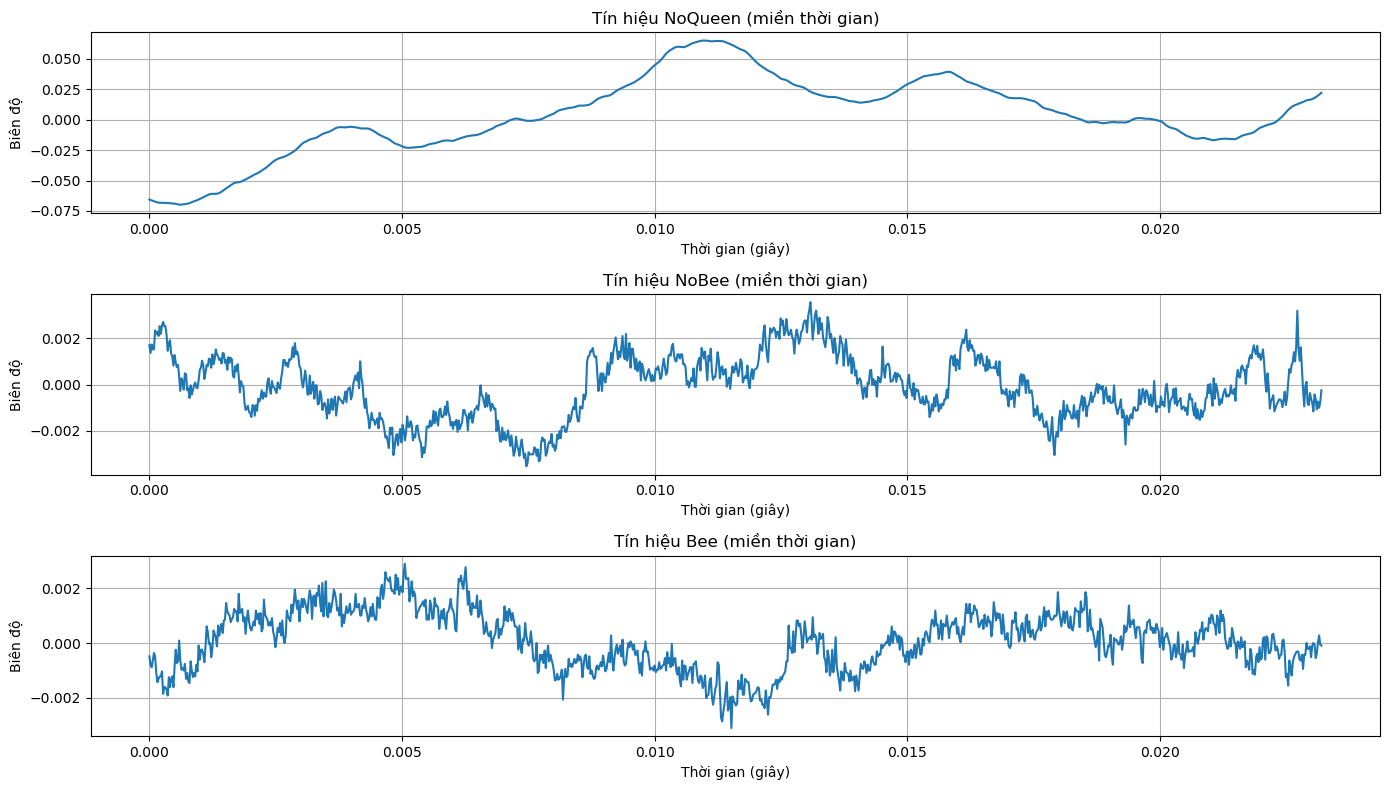

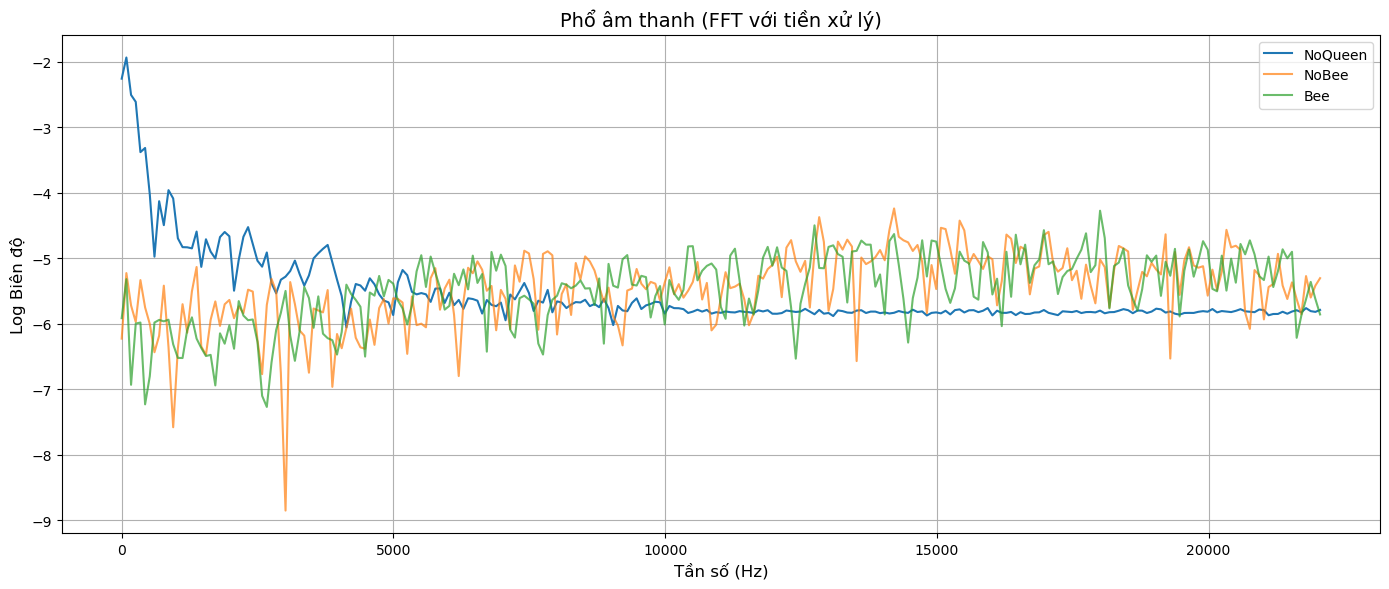

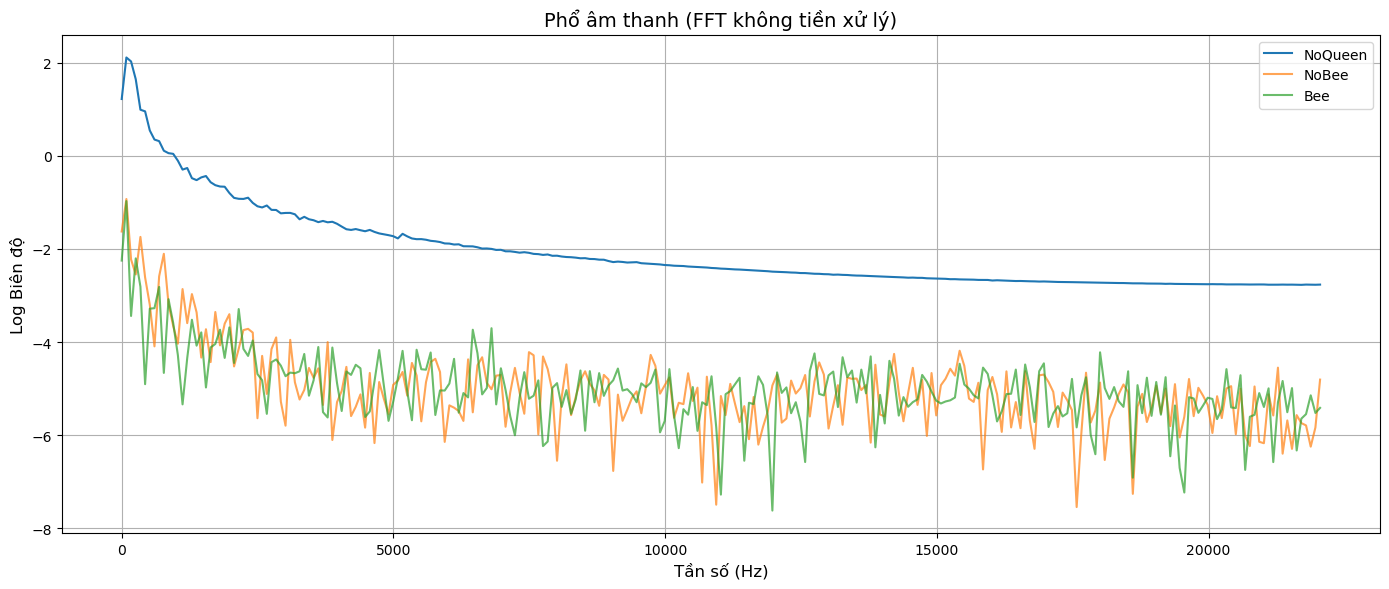

In [15]:
def pre_emphasis(signal_in, pre_emph=0.97):
    """
    Áp dụng pre-emphasis để nhấn mạnh các tần số cao.
    """
    return np.append(signal_in[0], signal_in[1:] - pre_emph * signal_in[:-1])

def framing(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01):
    """
    Chia tín hiệu thành các frame có kích thước và bước nhảy xác định.
    """
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(signal_in)
    num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal_in, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    return frames

def windowing(frames):
    """
    Áp dụng cửa sổ Hamming cho mỗi frame.
    """
    frame_length = frames.shape[1]
    hamming = np.hamming(frame_length)
    return frames * hamming

def fft_frames(frames, NFFT=512):
    """
    Tính FFT cho mỗi frame và lấy giá trị magnitude.
    """
    return np.absolute(np.fft.rfft(frames, NFFT))

def compute_fft_features(signal_in, sample_rate, frame_size=0.025, frame_stride=0.01, NFFT=512, apply_log=True):
    """
    Tính toán đặc trưng FFT cho tín hiệu âm thanh:
      - Pre-emphasis, Framing, Windowing.
      - Tính FFT cho từng frame và lấy giá trị magnitude.
      - Trung bình các frame để có vector đặc trưng ổn định.
      - (Tùy chọn) Áp dụng log để giảm phạm vi giá trị.
      
    Trả về: vector đặc trưng có kích thước (NFFT/2+1,).
    """
    emphasized_signal = pre_emphasis(signal_in)
    frames = framing(emphasized_signal, sample_rate, frame_size, frame_stride)
    windowed_frames = windowing(frames)
    mag_frames = fft_frames(windowed_frames, NFFT)
    fft_feature = np.mean(mag_frames, axis=0)  # Trung bình theo các frame
    if apply_log:
        fft_feature = np.log(fft_feature + 1e-8)  # Thêm epsilon để tránh log(0)
    return fft_feature

# Hàm mới để tính FFT trực tiếp không qua 3 bước tiền xử lý
def compute_raw_fft(signal_in, NFFT=512, apply_log=True):
    """
    Tính toán FFT trực tiếp từ tín hiệu gốc không qua tiền xử lý
    """
    # Áp dụng FFT trực tiếp
    fft_result = np.fft.rfft(signal_in, NFFT)
    # Lấy magnitude
    magnitude = np.absolute(fft_result)
    
    if apply_log:
        # Áp dụng log để giảm phạm vi giá trị
        return np.log(magnitude + 1e-8)
    else:
        return magnitude

# Load the audio signals
signal_noqueen, rate_noqueen = librosa.load(audio_path_noqueen, sr=None)
signal_nobee, rate_nobee = librosa.load(audio_path_nobee, sr=None)
signal_bee, rate_bee = librosa.load(audio_path_bee, sr=None)

# Ensure we're working with equal length segments (all three signals)
segment_length = min(len(signal_noqueen), len(signal_nobee), len(signal_bee))
segment_length = min(segment_length, 1024)  # Limit to 1024 samples

signal_noqueen = signal_noqueen[:segment_length]
signal_nobee = signal_nobee[:segment_length]
signal_bee = signal_bee[:segment_length]

# Apply FFT processing to all three signals
NFFT = 512
frame_size = 0.025
frame_stride = 0.01

# Process with pre-emphasis, framing, and windowing
fft_feature_noqueen = compute_fft_features(signal_noqueen, rate_noqueen, frame_size, frame_stride, NFFT)
fft_feature_nobee = compute_fft_features(signal_nobee, rate_nobee, frame_size, frame_stride, NFFT)
fft_feature_bee = compute_fft_features(signal_bee, rate_bee, frame_size, frame_stride, NFFT)

# Process with raw FFT (no pre-processing)
raw_fft_noqueen = compute_raw_fft(signal_noqueen, NFFT)
raw_fft_nobee = compute_raw_fft(signal_nobee, NFFT)
raw_fft_bee = compute_raw_fft(signal_bee, NFFT)

# Calculate frequency bins for plotting
freq_bins = np.linspace(0, rate_noqueen/2, len(fft_feature_noqueen))
raw_freq_bins = np.linspace(0, rate_noqueen/2, len(raw_fft_noqueen))

# Create plots for time domain signals
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(signal_noqueen)) / rate_noqueen, signal_noqueen)
plt.title('Tín hiệu NoQueen (miền thời gian)', fontsize=12)
plt.xlabel('Thời gian (giây)')
plt.ylabel('Biên độ')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(signal_nobee)) / rate_nobee, signal_nobee)
plt.title('Tín hiệu NoBee (miền thời gian)', fontsize=12)
plt.xlabel('Thời gian (giây)')
plt.ylabel('Biên độ')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(np.arange(len(signal_bee)) / rate_bee, signal_bee)
plt.title('Tín hiệu Bee (miền thời gian)', fontsize=12)
plt.xlabel('Thời gian (giây)')
plt.ylabel('Biên độ')
plt.grid(True)

plt.tight_layout()
plt.show()

# Create plots for frequency domain - with pre-processing
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(freq_bins, fft_feature_noqueen, label='NoQueen')
plt.plot(freq_bins, fft_feature_nobee, label='NoBee', alpha=0.7)
plt.plot(freq_bins, fft_feature_bee, label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT với tiền xử lý)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots for frequency domain - without pre-processing (raw FFT)
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(raw_freq_bins, raw_fft_noqueen, label='NoQueen')
plt.plot(raw_freq_bins, raw_fft_nobee, label='NoBee', alpha=0.7)
plt.plot(raw_freq_bins, raw_fft_bee, label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT không tiền xử lý)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

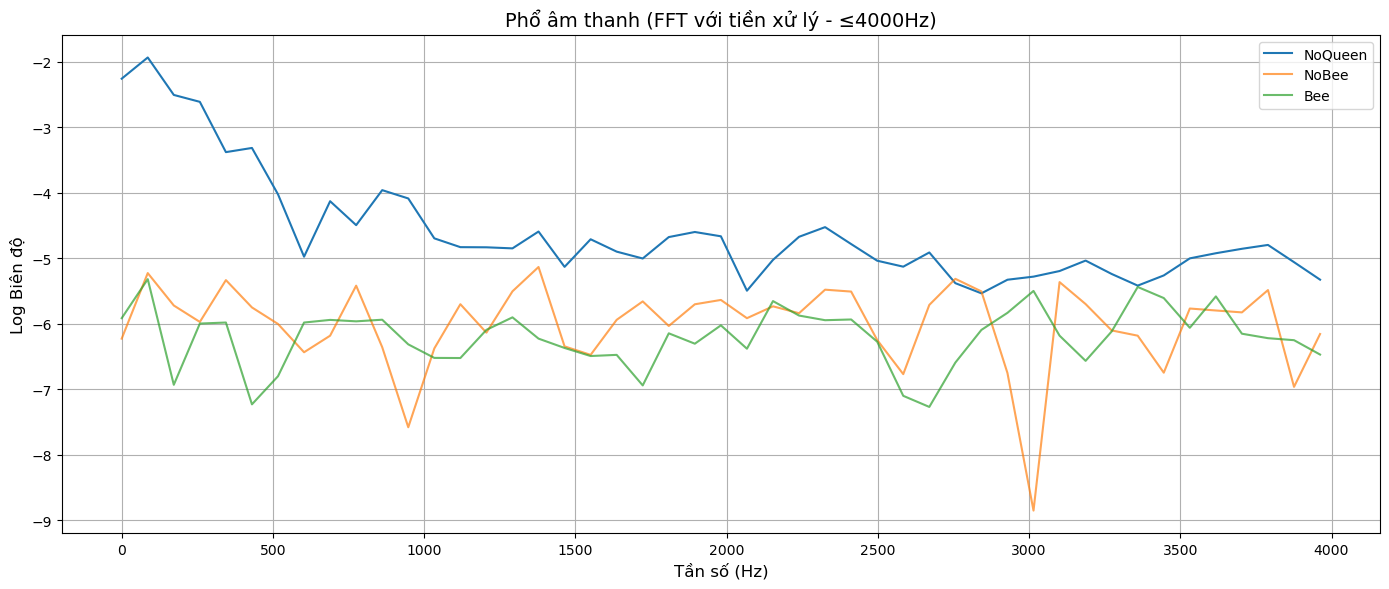

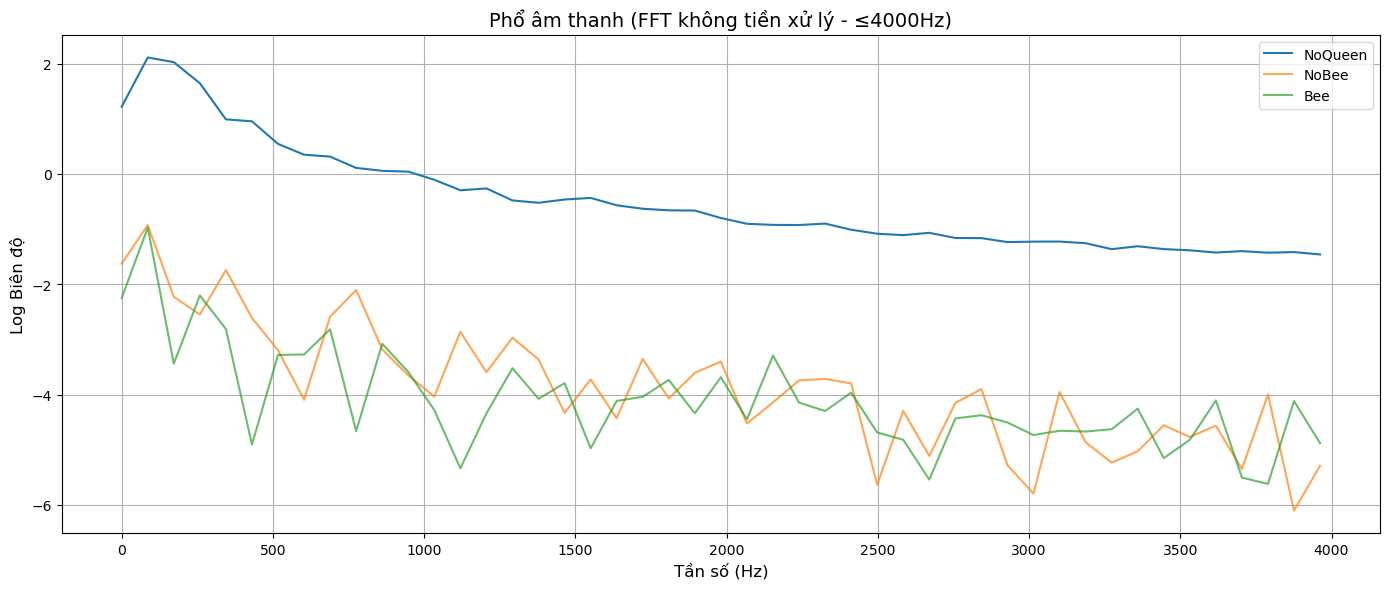

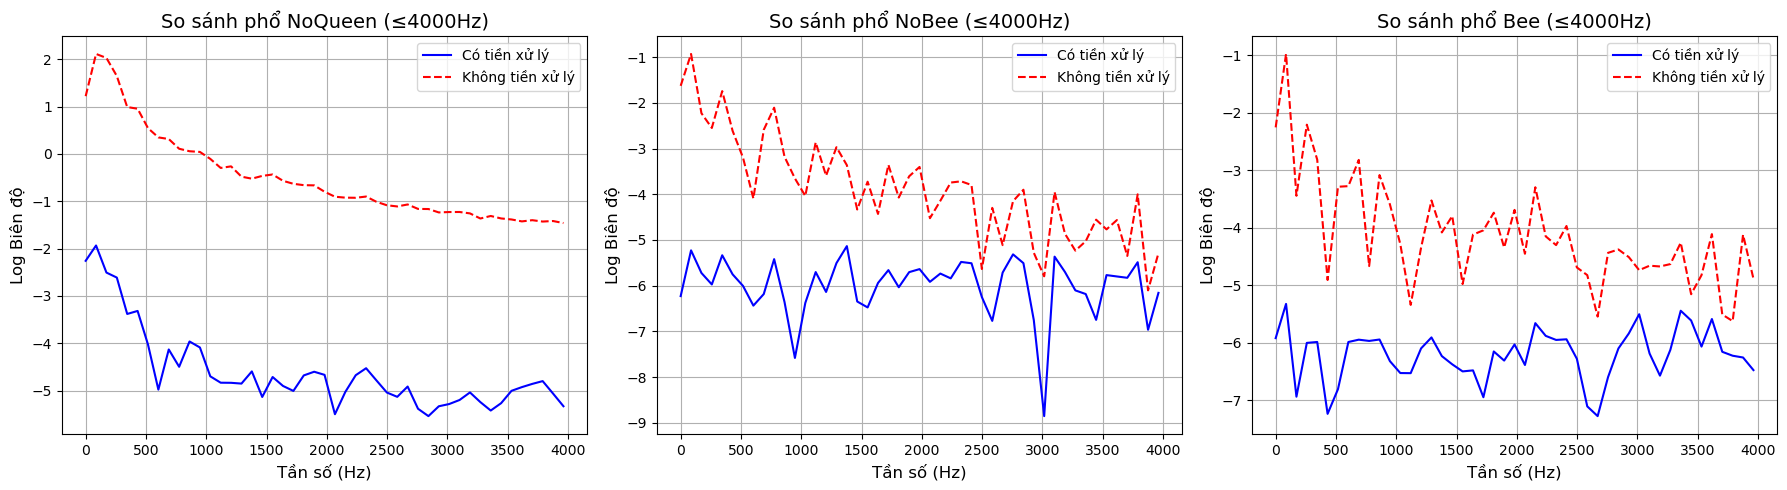

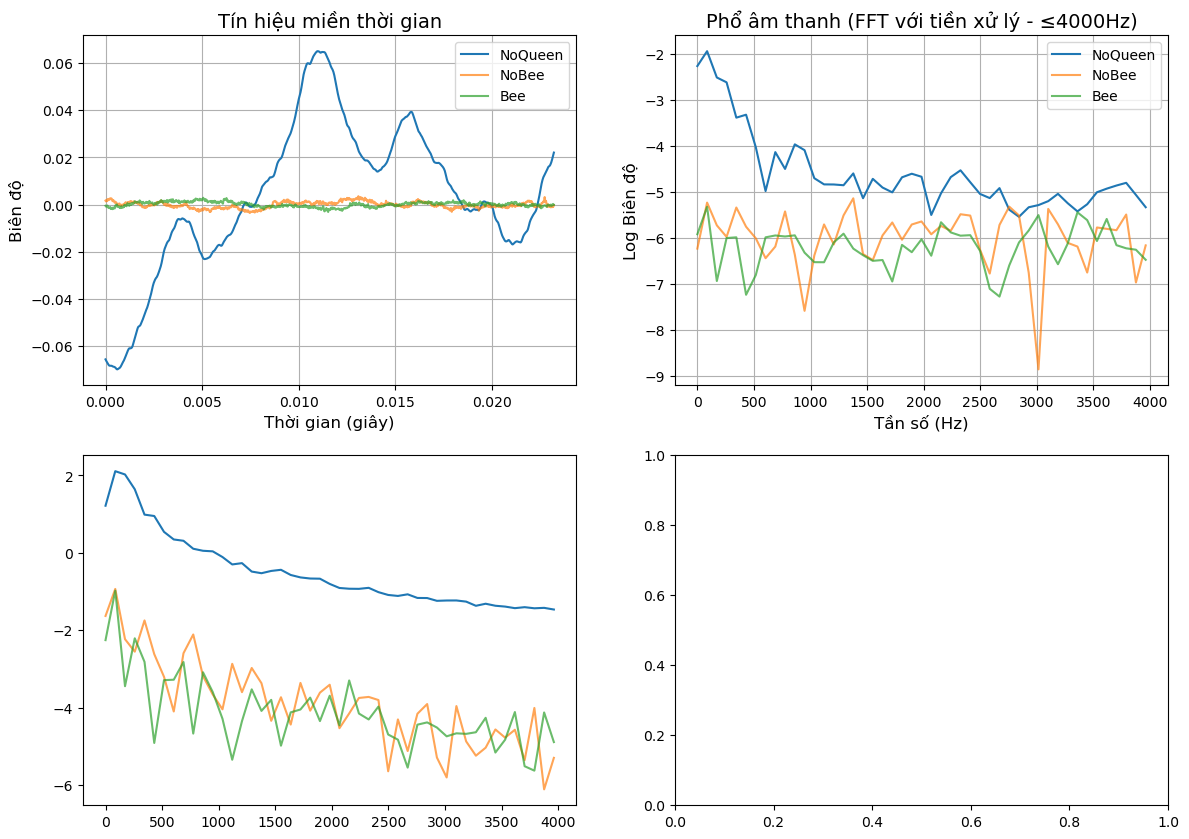

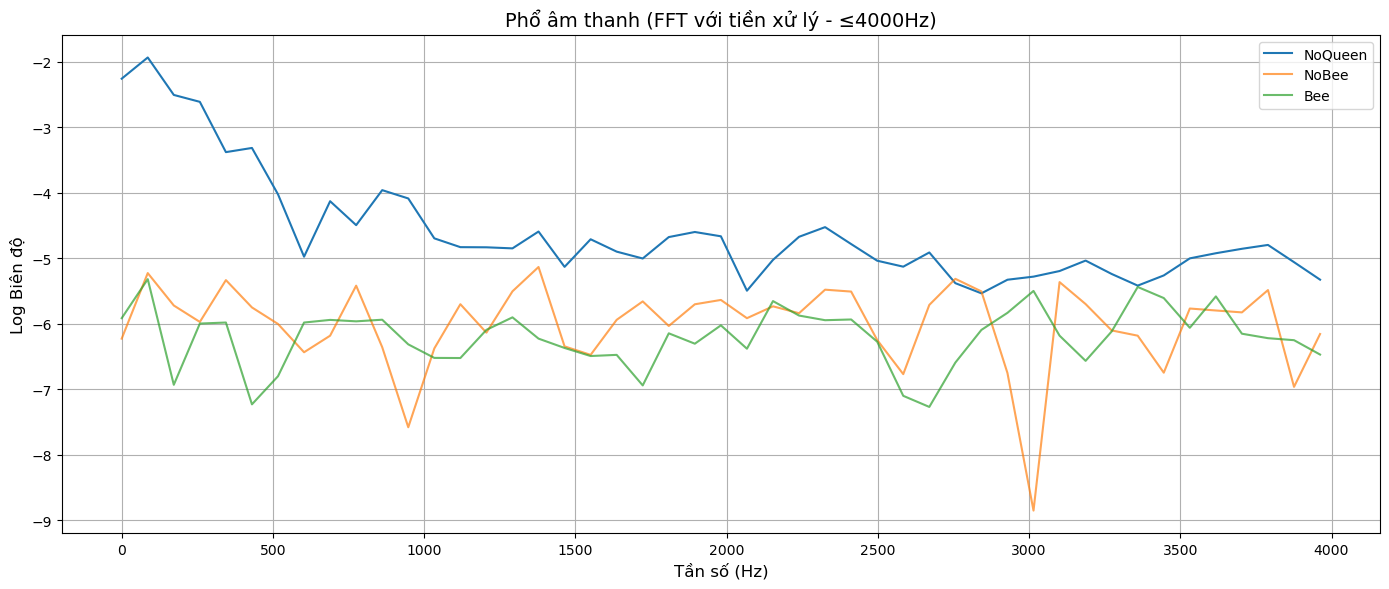

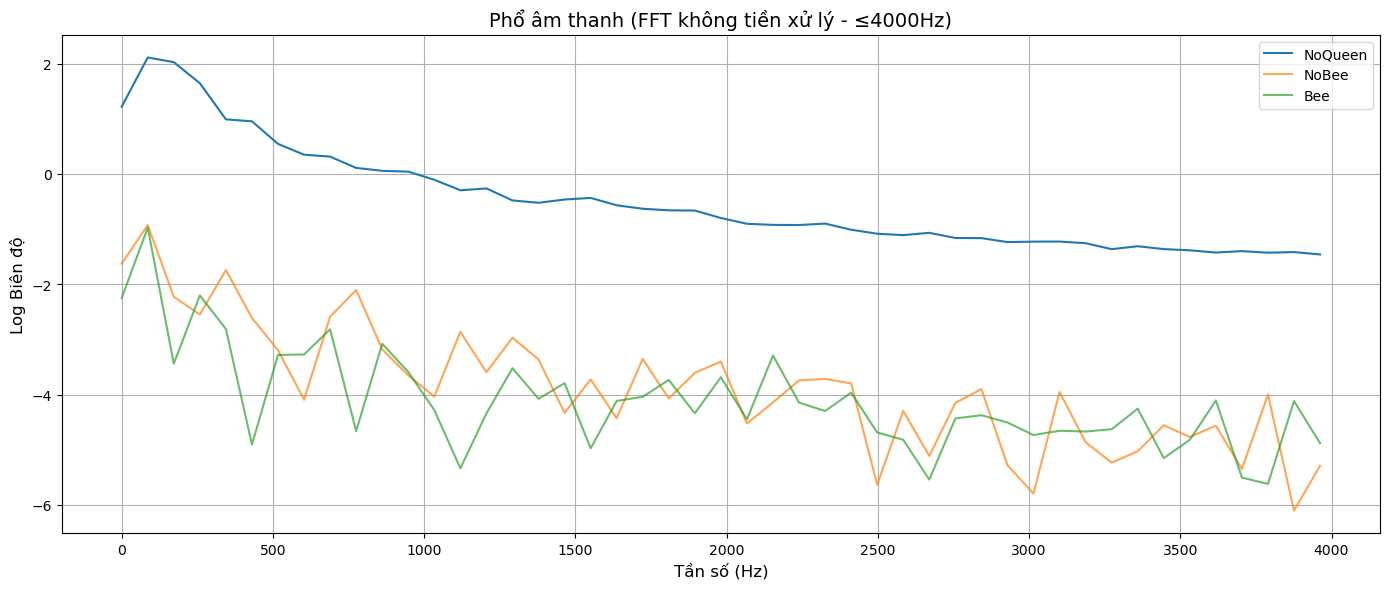

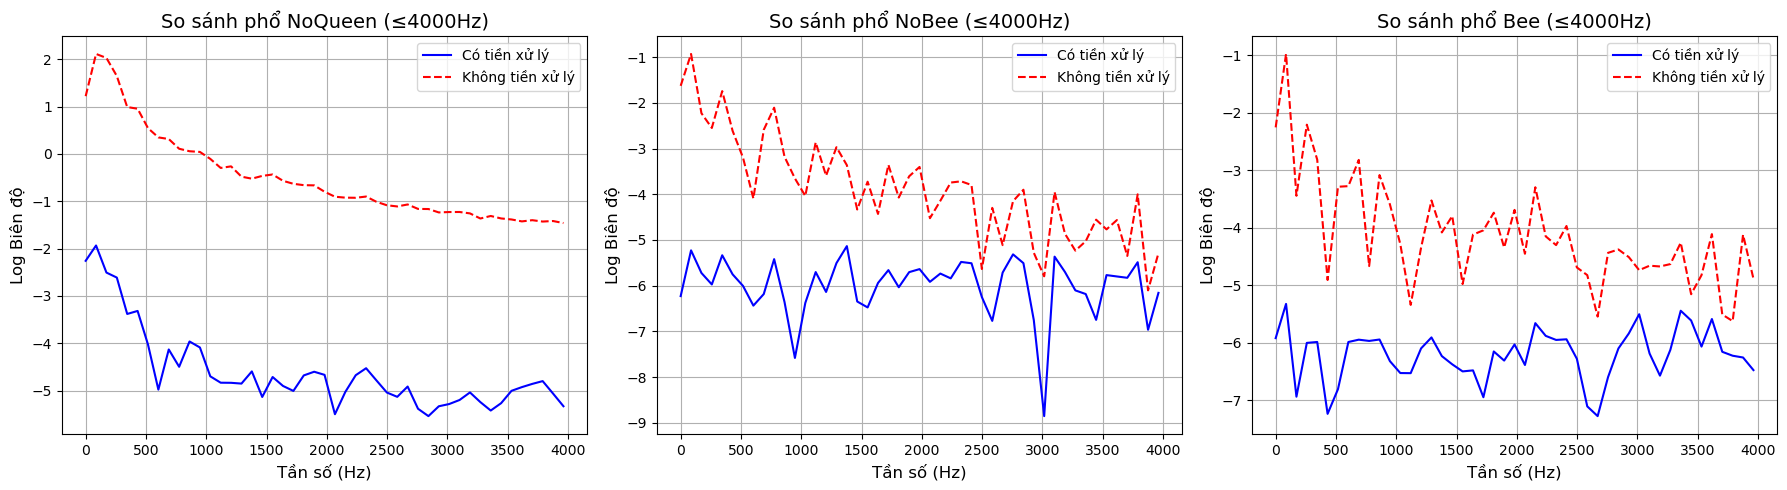

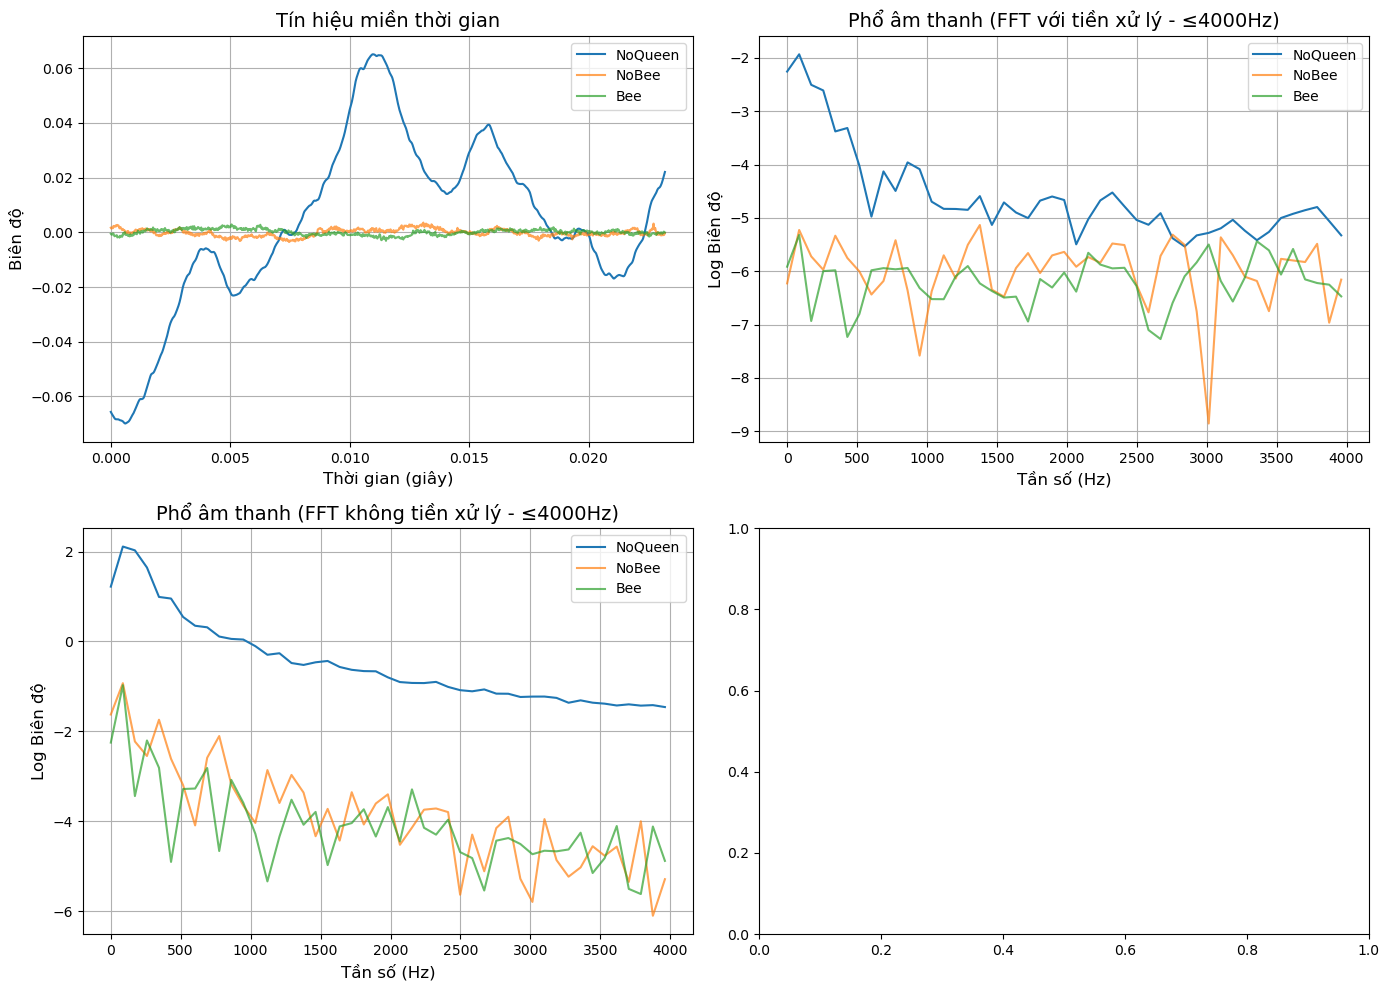

In [19]:
# Create frequency masks for 4000Hz cutoff
freq_mask = freq_bins <= 4000
raw_freq_mask = raw_freq_bins <= 4000

# Create plots - with pre-processing - limited to 4000Hz
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], label='NoQueen')
plt.plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], label='NoBee', alpha=0.7)
plt.plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT với tiền xử lý - ≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots - without pre-processing (raw FFT) - limited to 4000Hz
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], label='NoQueen')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], label='NoBee', alpha=0.7)
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT không tiền xử lý - ≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Detailed comparison - with and without pre-processing for each class
# NoQueen comparison
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ NoQueen (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

# NoBee comparison
plt.subplot(1, 3, 2)
plt.plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ NoBee (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

# Bee comparison
plt.subplot(1, 3, 3)
plt.plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ Bee (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional plot - 2x2 grid showing most important comparisons with 4000Hz limit
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot time domain signals - all three signals
axs[0, 0].plot(np.arange(len(signal_noqueen)) / rate_noqueen, signal_noqueen, label='NoQueen')
axs[0, 0].plot(np.arange(len(signal_nobee)) / rate_nobee, signal_nobee, label='NoBee', alpha=0.7)
axs[0, 0].plot(np.arange(len(signal_bee)) / rate_bee, signal_bee, label='Bee', alpha=0.7)
axs[0, 0].set_title('Tín hiệu miền thời gian', fontsize=14)
axs[0, 0].set_xlabel('Thời gian (giây)', fontsize=12)
axs[0, 0].set_ylabel('Biên độ', fontsize=12)
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot FFT features (log magnitude) - with preprocessing - limited to 4000Hz
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], label='NoQueen')
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], label='NoBee', alpha=0.7)
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], label='Bee', alpha=0.7)
axs[0, 1].set_title('Phổ âm thanh (FFT với tiền xử lý - ≤4000Hz)', fontsize=14)
axs[0, 1].set_xlabel('Tần số (Hz)', fontsize=12)
axs[0, 1].set_ylabel('Log Biên độ', fontsize=12)
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot FFT features (log magnitude) - without preprocessing (raw FFT) - limited to 4000Hz
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], label='NoQueen')
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], label='NoBee', alpha=0.7)
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], label='Bee', alpha=0.7)
# Create frequency masks for 4000Hz cutoff
freq_mask = freq_bins <= 4000
raw_freq_mask = raw_freq_bins <= 4000

# Create plots - with pre-processing - limited to 4000Hz
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], label='NoQueen')
plt.plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], label='NoBee', alpha=0.7)
plt.plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT với tiền xử lý - ≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create plots - without pre-processing (raw FFT) - limited to 4000Hz
plt.figure(figsize=(14, 6))
plt.subplot(1, 1, 1)
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], label='NoQueen')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], label='NoBee', alpha=0.7)
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], label='Bee', alpha=0.7)
plt.title('Phổ âm thanh (FFT không tiền xử lý - ≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Detailed comparison - with and without pre-processing for each class
# NoQueen comparison
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ NoQueen (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

# NoBee comparison
plt.subplot(1, 3, 2)
plt.plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ NoBee (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

# Bee comparison
plt.subplot(1, 3, 3)
plt.plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], 'b', label='Có tiền xử lý')
plt.plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], 'r--', label='Không tiền xử lý')
plt.title('So sánh phổ Bee (≤4000Hz)', fontsize=14)
plt.xlabel('Tần số (Hz)', fontsize=12)
plt.ylabel('Log Biên độ', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Additional plot - 2x2 grid showing most important comparisons with 4000Hz limit
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot time domain signals - all three signals
axs[0, 0].plot(np.arange(len(signal_noqueen)) / rate_noqueen, signal_noqueen, label='NoQueen')
axs[0, 0].plot(np.arange(len(signal_nobee)) / rate_nobee, signal_nobee, label='NoBee', alpha=0.7)
axs[0, 0].plot(np.arange(len(signal_bee)) / rate_bee, signal_bee, label='Bee', alpha=0.7)
axs[0, 0].set_title('Tín hiệu miền thời gian', fontsize=14)
axs[0, 0].set_xlabel('Thời gian (giây)', fontsize=12)
axs[0, 0].set_ylabel('Biên độ', fontsize=12)
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot FFT features (log magnitude) - with preprocessing - limited to 4000Hz
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_noqueen[freq_mask], label='NoQueen')
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_nobee[freq_mask], label='NoBee', alpha=0.7)
axs[0, 1].plot(freq_bins[freq_mask], fft_feature_bee[freq_mask], label='Bee', alpha=0.7)
axs[0, 1].set_title('Phổ âm thanh (FFT với tiền xử lý - ≤4000Hz)', fontsize=14)
axs[0, 1].set_xlabel('Tần số (Hz)', fontsize=12)
axs[0, 1].set_ylabel('Log Biên độ', fontsize=12)
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot FFT features (log magnitude) - without preprocessing (raw FFT) - limited to 4000Hz
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_noqueen[raw_freq_mask], label='NoQueen')
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_nobee[raw_freq_mask], label='NoBee', alpha=0.7)
axs[1, 0].plot(raw_freq_bins[raw_freq_mask], raw_fft_bee[raw_freq_mask], label='Bee', alpha=0.7)
axs[1, 0].set_title('Phổ âm thanh (FFT không tiền xử lý - ≤4000Hz)', fontsize=14)
axs[1, 0].set_xlabel('Tần số (Hz)', fontsize=12)

axs[1, 0].set_ylabel('Log Biên độ', fontsize=12)
axs[1, 0].legend()
axs[1, 0].grid(True)

plt.tight_layout()
plt.show()



Constant-Q Transform (CQT)

C:\Users\dinhg\AppData\Local\Temp\ipykernel_18968\1344088328.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  X_cq[k-1, n] = np.sum(window)


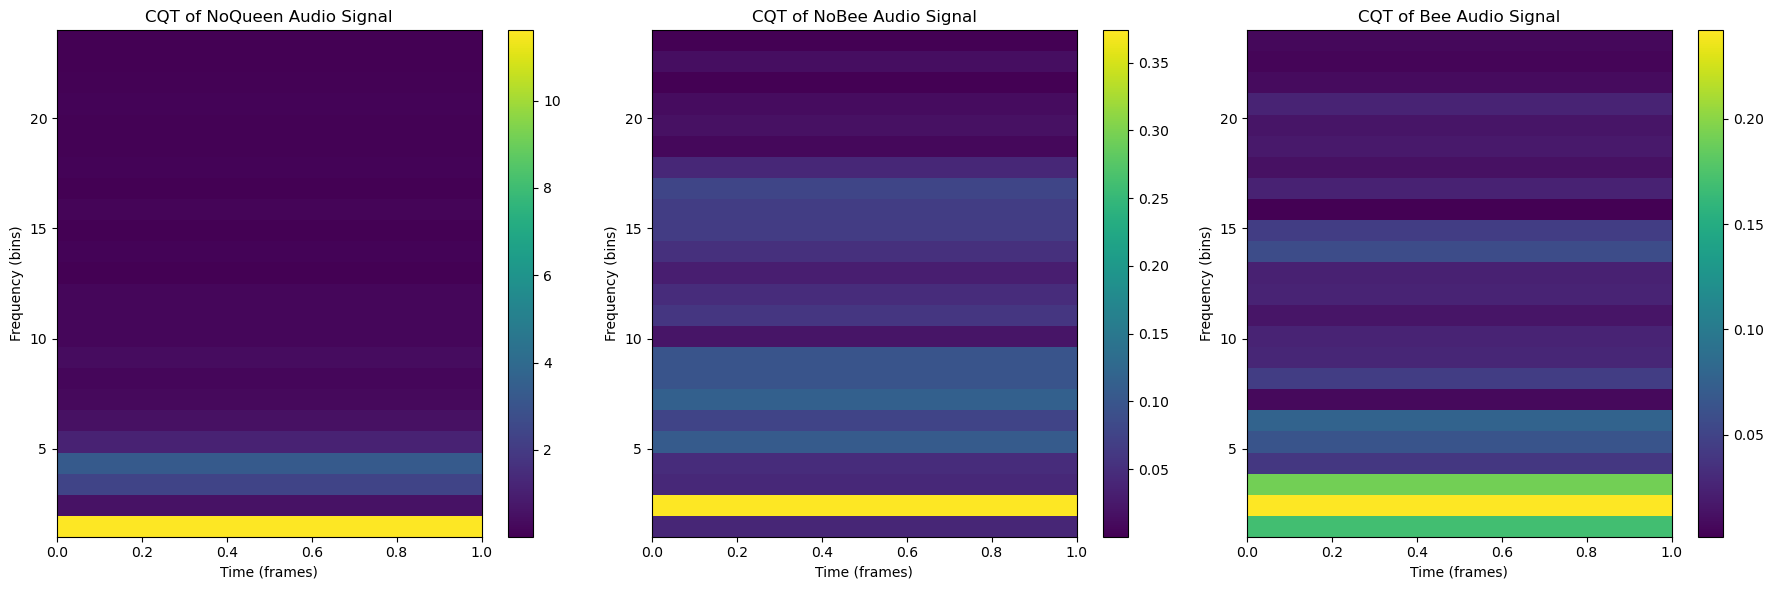

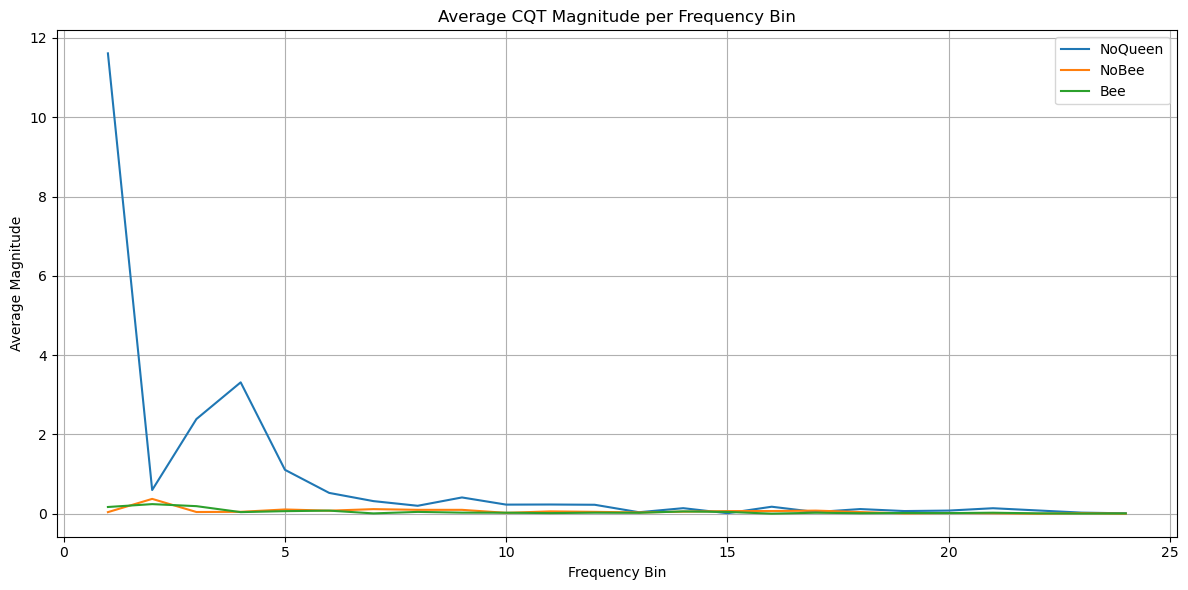

In [25]:
def cqt_transform(x, sr, N=1024, K=24):
    """
    Tính toán Constant-Q Transform (CQT) của tín hiệu x.
    
    Args:
    - x: Tín hiệu đầu vào (mảng numpy)
    - sr: Tỷ lệ lấy mẫu (sampling rate)
    - N: Kích thước của tín hiệu (số mẫu) trên mỗi khung
    - K: Số lượng bin tần số (frequency bins)

    Returns:
    - X_cq: CQT của tín hiệu (biến đổi Fourier với tần số logarithmic)
    """
    X_cq = np.zeros((K, len(x)//N))
    
    # Tính toán CQT cho từng khung thời gian
    for n in range(len(x) // N):
        # Tạo cửa sổ CQT với tần số logarithmic
        for k in range(1, K+1):
            window_size = int(N / (2**(k / K)))  # Tính độ rộng cửa sổ cho từng bin tần số
            start = max(n * N - window_size // 2, 0)
            end = min(n * N + window_size // 2, len(x))
            
            # Kiểm tra cửa sổ có hợp lệ không
            if start >= end:
                continue  # Bỏ qua nếu cửa sổ không hợp lệ

            # Chỉ khởi tạo window khi cửa sổ hợp lệ
            window = x[start:end] * np.exp(-2j * np.pi * k * np.arange(len(x[start:end])) / N)
            
            # Tính toán phần thực của CQT
            X_cq[k-1, n] = np.sum(window)
    
    return X_cq

# Load the three audio signals
signal_noqueen, rate_noqueen = librosa.load(audio_path_noqueen, sr=None)
signal_nobee, rate_nobee = librosa.load(audio_path_nobee, sr=None)
signal_bee, rate_bee = librosa.load(audio_path_bee, sr=None)

# Ensure we're working with equal length segments for all signals
min_length = min(len(signal_noqueen), len(signal_nobee), len(signal_bee))
segment_length = min(min_length, 1024)  # Use at most 1024 samples

# Trim signals to the same length
signal_noqueen = signal_noqueen[:segment_length]
signal_nobee = signal_nobee[:segment_length]
signal_bee = signal_bee[:segment_length]

# Apply CQT to all three signals
X_cq_noqueen = cqt_transform(signal_noqueen, rate_noqueen)
X_cq_nobee = cqt_transform(signal_nobee, rate_nobee)
X_cq_bee = cqt_transform(signal_bee, rate_bee)

# Plot CQT spectra for all three signals
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for NoQueen signal
cax1 = axes[0].imshow(np.abs(X_cq_noqueen), aspect='auto', cmap='viridis', 
                      origin='lower', extent=[0, len(signal_noqueen)//1024, 1, 24])
fig.colorbar(cax1, ax=axes[0])
axes[0].set_title('CQT of NoQueen Audio Signal')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Frequency (bins)')

# Plot for NoBee signal
cax2 = axes[1].imshow(np.abs(X_cq_nobee), aspect='auto', cmap='viridis', 
                      origin='lower', extent=[0, len(signal_nobee)//1024, 1, 24])
fig.colorbar(cax2, ax=axes[1])
axes[1].set_title('CQT of NoBee Audio Signal')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Frequency (bins)')

# Plot for Bee signal
cax3 = axes[2].imshow(np.abs(X_cq_bee), aspect='auto', cmap='viridis', 
                      origin='lower', extent=[0, len(signal_bee)//1024, 1, 24])
fig.colorbar(cax3, ax=axes[2])
axes[2].set_title('CQT of Bee Audio Signal')
axes[2].set_xlabel('Time (frames)')
axes[2].set_ylabel('Frequency (bins)')

plt.tight_layout()
plt.show()

# Also plot a comparison of average magnitudes across frequencies
plt.figure(figsize=(12, 6))

# Calculate average magnitude for each frequency bin
avg_mag_noqueen = np.mean(np.abs(X_cq_noqueen), axis=1)
avg_mag_nobee = np.mean(np.abs(X_cq_nobee), axis=1)
avg_mag_bee = np.mean(np.abs(X_cq_bee), axis=1)

# Plot average magnitudes
freq_bins = np.arange(1, 25)
plt.plot(freq_bins, avg_mag_noqueen, label='NoQueen')
plt.plot(freq_bins, avg_mag_nobee, label='NoBee')
plt.plot(freq_bins, avg_mag_bee, label='Bee')
plt.title('Average CQT Magnitude per Frequency Bin')
plt.xlabel('Frequency Bin')
plt.ylabel('Average Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

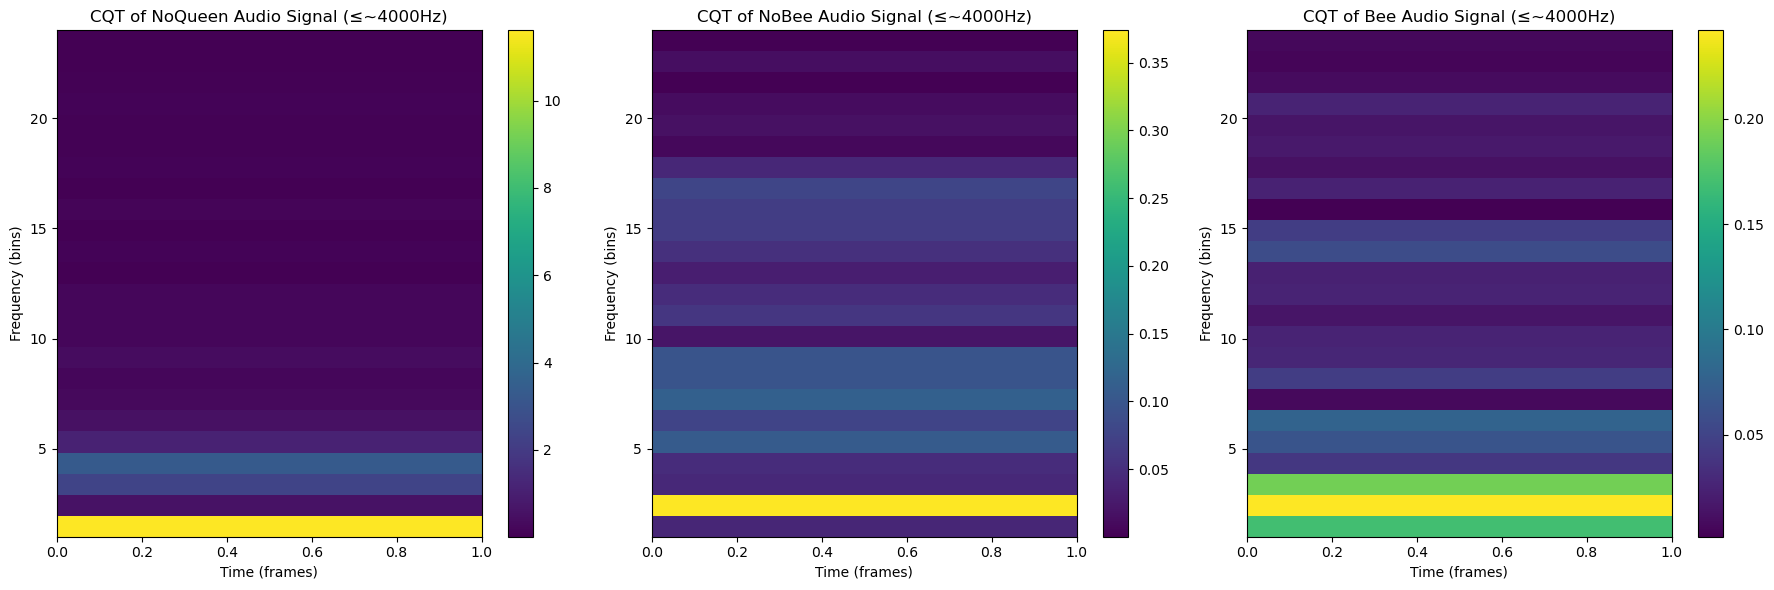

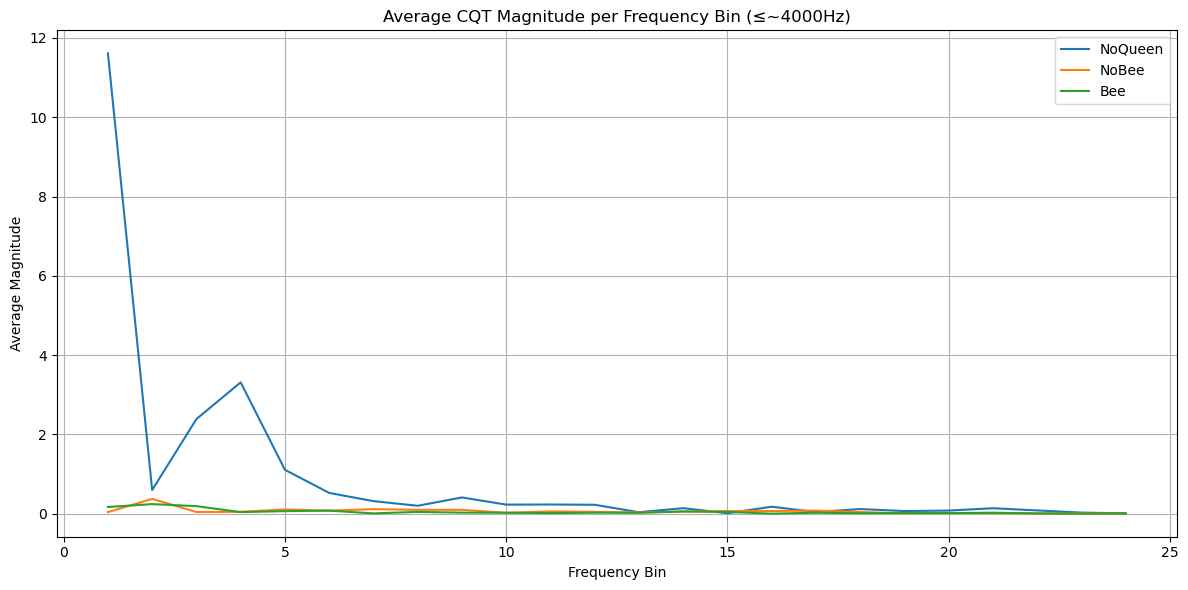

Approximate frequency values for selected CQT bins:
---------------------------------------------------
Bin | Frequency (Hz)
---------------------------------------------------
  0 | 20.0
  5 | 23.1
 10 | 26.7
 15 | 30.8
 20 | 35.6
 24 | 38.9 (frequency limit)
---------------------------------------------------


In [24]:
# Convert frequency bins to approximate Hz values for visualization
def freq_bin_to_hz(bin_idx, sr=44100, K=24):
    """
    Convert CQT frequency bin to approximate Hz value.
    Using the formula: f_k = f_min * 2^(k/K) where f_min is the minimum frequency.
    For simplicity, we'll use f_min = 20Hz (common minimum for audio analysis)
    """
    f_min = 20  # Minimum frequency in Hz
    return f_min * (2 ** (bin_idx / K))

# Calculate Hz values for each bin
hz_values = [freq_bin_to_hz(i) for i in range(24)]

# Find the bin index corresponding to approximately 4000Hz
freq_limit_bin = next((i for i, hz in enumerate(hz_values) if hz > 4000), 24)

# Plot CQT spectra with frequency limitation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for NoQueen signal with frequency limitation
limited_cq_noqueen = X_cq_noqueen[:freq_limit_bin, :]
cax1 = axes[0].imshow(np.abs(limited_cq_noqueen), aspect='auto', cmap='viridis',
                      origin='lower', extent=[0, len(signal_noqueen)//1024, 1, freq_limit_bin])
fig.colorbar(cax1, ax=axes[0])
axes[0].set_title(f'CQT of NoQueen Audio Signal (≤~4000Hz)')
axes[0].set_xlabel('Time (frames)')
axes[0].set_ylabel('Frequency (bins)')

# Plot for NoBee signal with frequency limitation
limited_cq_nobee = X_cq_nobee[:freq_limit_bin, :]
cax2 = axes[1].imshow(np.abs(limited_cq_nobee), aspect='auto', cmap='viridis',
                      origin='lower', extent=[0, len(signal_nobee)//1024, 1, freq_limit_bin])
fig.colorbar(cax2, ax=axes[1])
axes[1].set_title(f'CQT of NoBee Audio Signal (≤~4000Hz)')
axes[1].set_xlabel('Time (frames)')
axes[1].set_ylabel('Frequency (bins)')

# Plot for Bee signal with frequency limitation
limited_cq_bee = X_cq_bee[:freq_limit_bin, :]
cax3 = axes[2].imshow(np.abs(limited_cq_bee), aspect='auto', cmap='viridis',
                      origin='lower', extent=[0, len(signal_bee)//1024, 1, freq_limit_bin])
fig.colorbar(cax3, ax=axes[2])
axes[2].set_title(f'CQT of Bee Audio Signal (≤~4000Hz)')
axes[2].set_xlabel('Time (frames)')
axes[2].set_ylabel('Frequency (bins)')

plt.tight_layout()
plt.show()

# Plot frequency-limited average magnitudes
plt.figure(figsize=(12, 6))

# Calculate average magnitude for limited frequency bins
avg_mag_noqueen_limited = np.mean(np.abs(limited_cq_noqueen), axis=1)
avg_mag_nobee_limited = np.mean(np.abs(limited_cq_nobee), axis=1)  
avg_mag_bee_limited = np.mean(np.abs(limited_cq_bee), axis=1)

# Plot average magnitudes with frequency limitation
limited_freq_bins = np.arange(1, freq_limit_bin+1)
plt.plot(limited_freq_bins, avg_mag_noqueen_limited, label='NoQueen')
plt.plot(limited_freq_bins, avg_mag_nobee_limited, label='NoBee')
plt.plot(limited_freq_bins, avg_mag_bee_limited, label='Bee')
plt.title(f'Average CQT Magnitude per Frequency Bin (≤~4000Hz)')
plt.xlabel('Frequency Bin')
plt.ylabel('Average Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display a table of approximate frequency ranges
print("Approximate frequency values for selected CQT bins:")
print("---------------------------------------------------")
print("Bin | Frequency (Hz)")
print("---------------------------------------------------")
for i in range(0, freq_limit_bin, 5):  # Print every 5th bin for readability
    print(f"{i:3d} | {hz_values[i]:.1f}")
print(f"{freq_limit_bin:3d} | {hz_values[freq_limit_bin-1]:.1f} (frequency limit)")
print("---------------------------------------------------")